In [5]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
import scipy.misc
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *


In [6]:
def load_cifar(path):
    with open(path, mode='rb') as f:
        batch = pickle.load(f, encoding='latin1')
    images = batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
    labels = batch['labels']
    images,labels=data_preproc(images,labels)
    return images,labels

def data_preproc(cifar_images,cifar_labels):
    cifar_labels = np.asarray(cifar_labels)
    cifar_labels = cifar_labels.astype(np.uint8)
    
    def normalize(features):
        min_val = np.min(features)
        max_val = np.max(features)
        x = (features - min_val) / (max_val - min_val)
        return x
    
    cifar_images = np.float64(cifar_images)
    
    for i in range (0, cifar_images.shape[0]):
        cifar_images[i]= normalize(cifar_images[i])
    
    cifar_images = np.float64(cifar_images)
    
    return cifar_images,cifar_labels

for a in range (0,5):
    file_name ='cifar-10-batches-py/data_batch_'+str(a+1)
    cifar_temp,cifar_labels=load_cifar(file_name)
    if a ==0:
        cifar_images_train=cifar_temp
        cifar_labels_train=cifar_labels
    if a>0:
        cifar_images_train=np.append(cifar_images_train, cifar_temp)
        cifar_labels_train=np.append(cifar_labels_train, cifar_labels)

cifar_images_train=cifar_images_train.reshape(cifar_labels_train.shape[0],
                                              cifar_temp.shape[1],
                                              cifar_temp.shape[2],
                                              cifar_temp.shape[3])

cifar_images_test, cifar_labels_test=load_cifar("cifar-10-batches-py/test_batch")

In [7]:
def one_hot_encode(labels):
	encoded = np.zeros((len(labels),10))
	for idx,val in enumerate(labels):
		encoded[idx][val] = 1
	return encoded

training_images = cifar_images_train
training_labels = one_hot_encode(cifar_labels_train)
train_labels = cifar_labels_train

validation_images = (cifar_images_test[:5000])
validation_labels = one_hot_encode(cifar_labels_test[:5000])

testing_images = cifar_images_test
testing_labels = one_hot_encode(cifar_labels_test)
test_lbl = cifar_labels_test


In [109]:
import warnings
warnings.filterwarnings('ignore')
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
iteration = 50
stride_size = 2
filter_size = 5

'''Make a Deep Learning Model'''
model = Sequential()

model.add(Conv2D(16,kernel_size=filter_size,strides=stride_size,activation='relu',
                             input_shape = cifar_images_train.shape[1:],kernel_regularizer=regularizers.l2()))
model.add(Conv2D(16,kernel_size=filter_size,strides=stride_size,activation='relu',kernel_regularizer=regularizers.l2()))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Default GPU Device: /device:GPU:0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 14, 14, 16)        1216      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 5, 5, 16)          6416      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 10)                650       
Total params: 12,442
Trainable params: 12,442
Non-trainable params: 0
______________________________________

In [110]:

cnn = model.fit(training_images, training_labels, validation_data=(validation_images, validation_labels), 
                epochs = iteration,batch_size=128)


Train on 50000 samples, validate on 5000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 86us/step - loss: 2.0375 - acc: 0.2834 - val_loss: 1.8326 - val_acc: 0.3626
Epoch 2/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.7799 - acc: 0.3835 - val_loss: 1.7512 - val_acc: 0.4062
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.7071 - acc: 0.4131 - val_loss: 1.6728 - val_acc: 0.4278
Epoch 4/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.6617 - acc: 0.4275 - val_loss: 1.6346 - val_acc: 0.4430
Epoch 5/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.6215 - acc: 0.4463 - val_loss: 1.6032 - val_acc: 0.4638
Epoch 6/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.5917 - acc: 0.4564 - val_loss: 1.5662 - val_acc: 0.4706
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.5694 - acc: 0.4643 - val_loss: 1.5665 - val_acc:

In [113]:
scores = model.evaluate(testing_images, testing_labels, batch_size=128, verbose=1)
print('\nTest Accuracy: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 0s 49us/step

Test Accuracy: 53.810 loss: 1.406


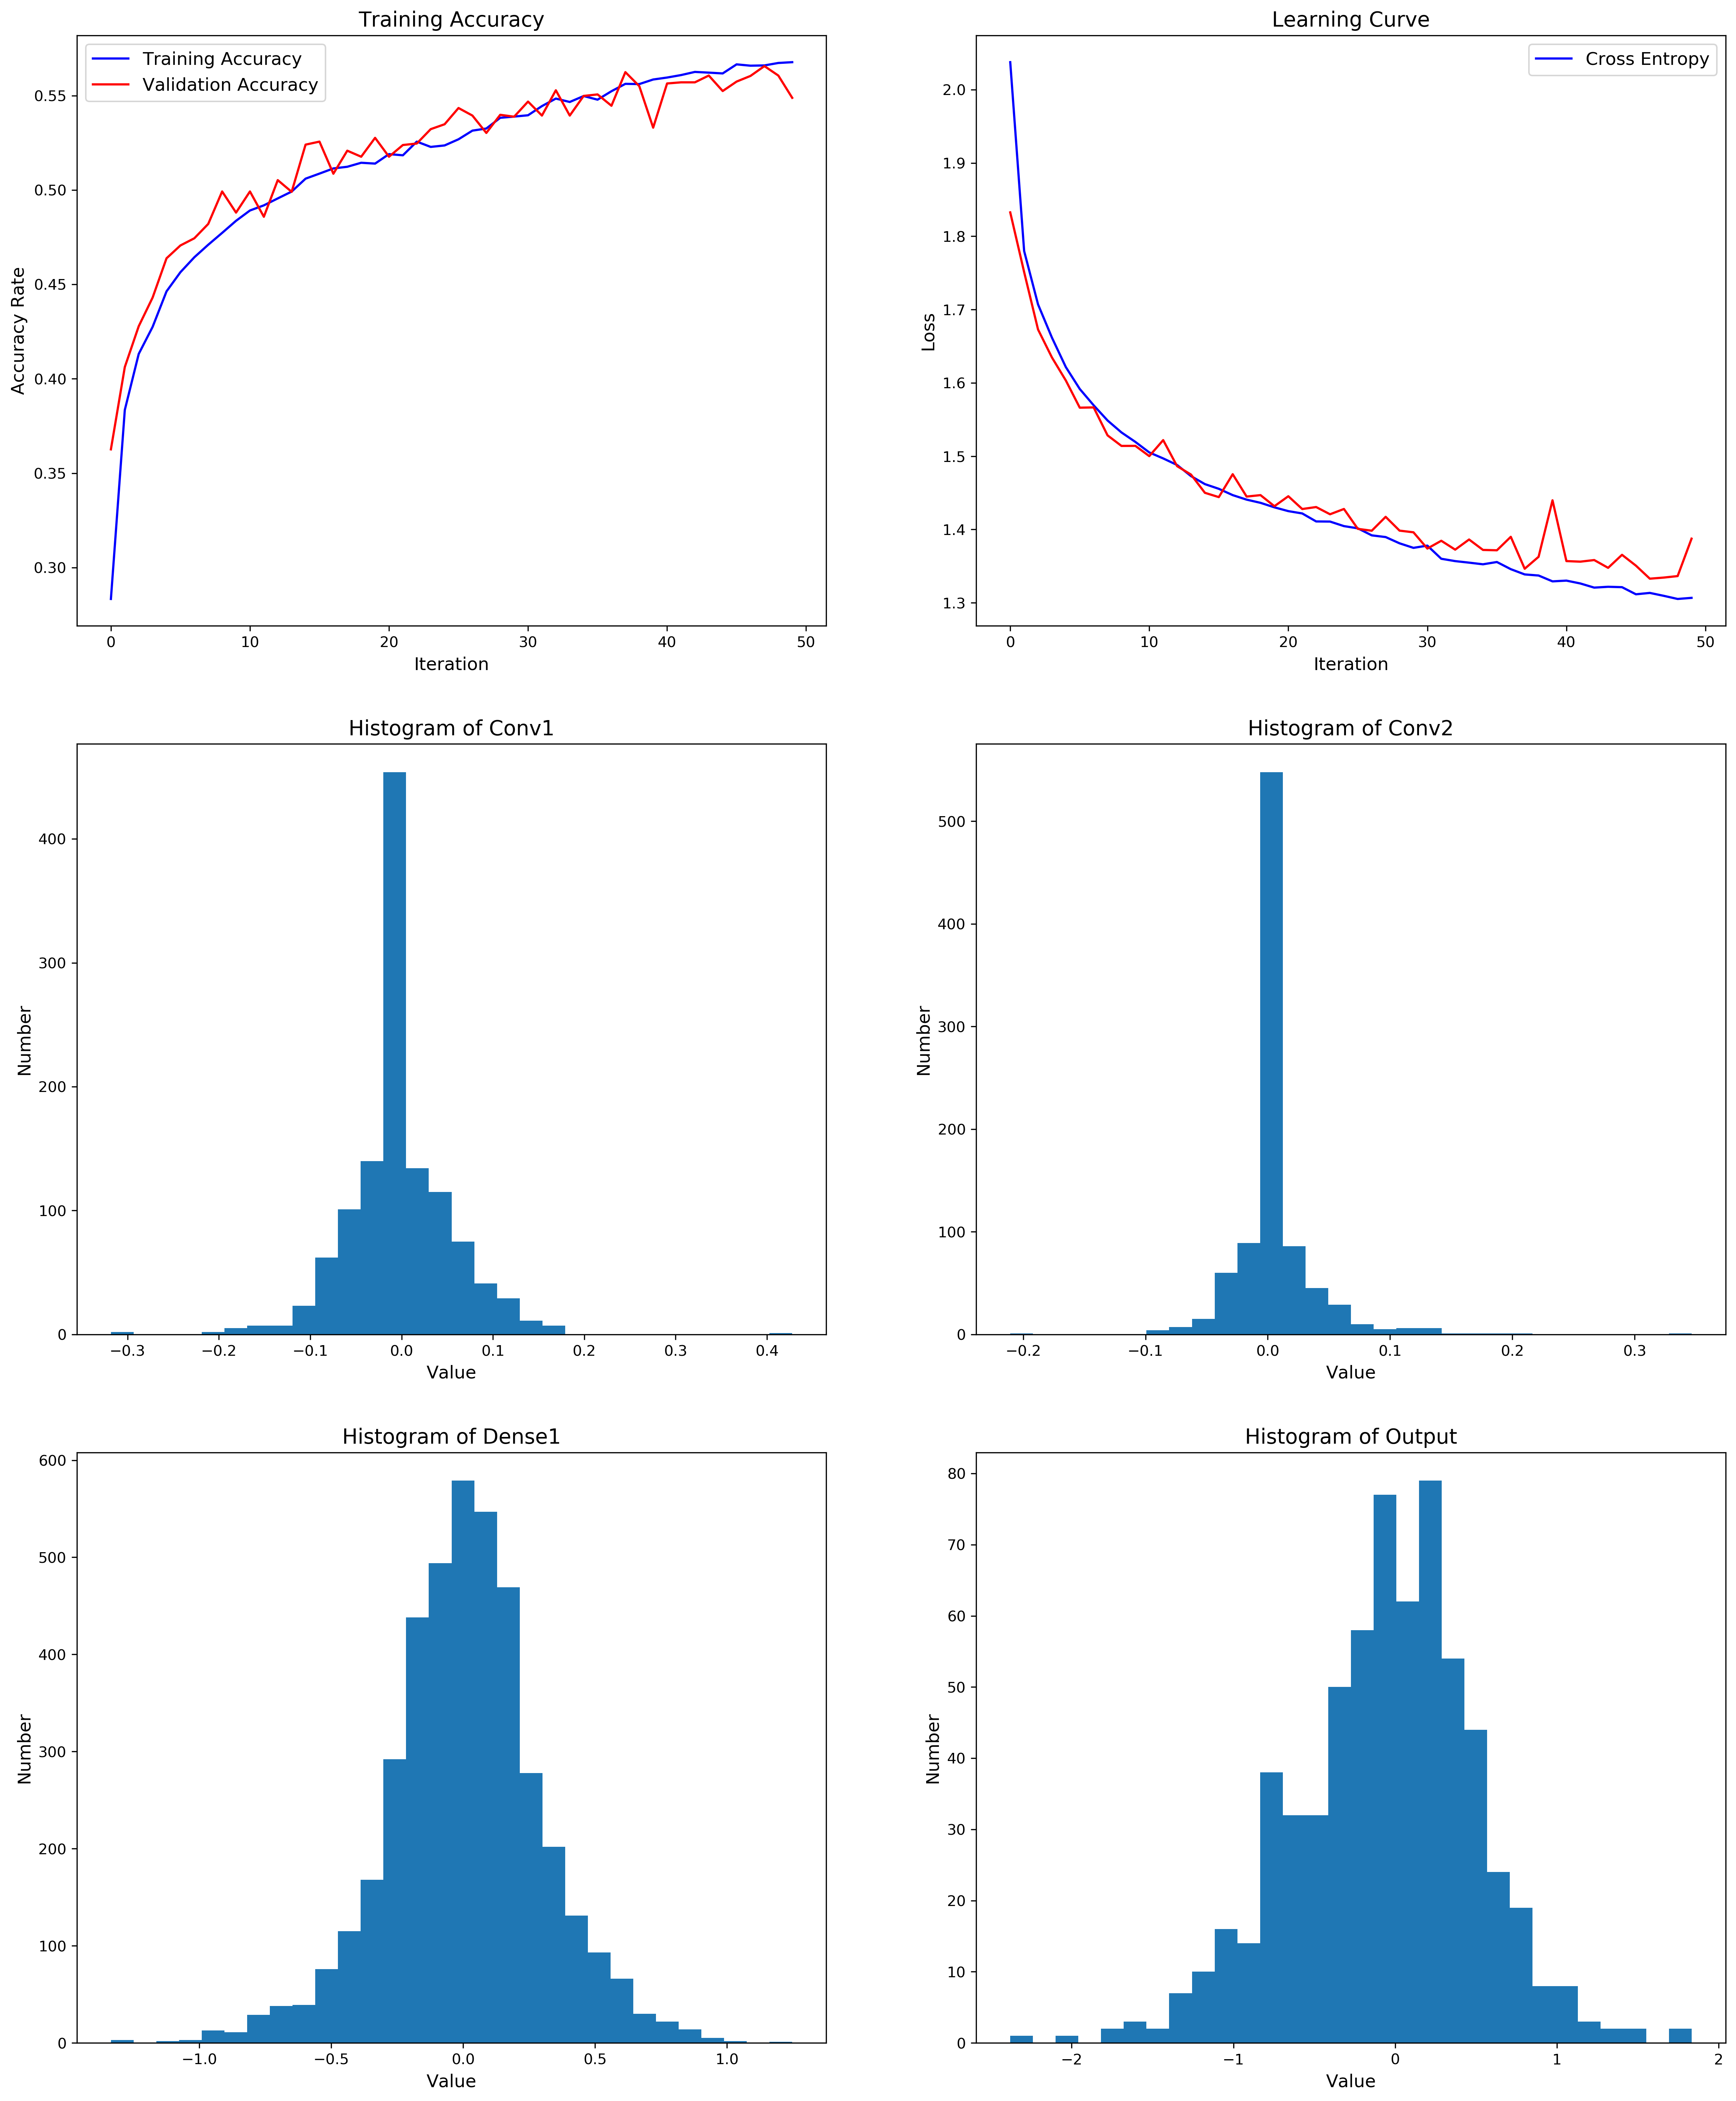

In [112]:
np.set_printoptions(suppress=True)
weight = []
for i in range(0,len(model.layers)):
    weights = model.layers[i].get_weights()
    if len(weights) > 0:
        weight.append(weights)
        
for i in range(0,len(weight)):
    layer_weight = []
    for j in range(0,len(weight[i])):
        for k in range(0,len(weight[i][j])):
            layer_weight.append(weight[i][j][k])
    with open('layer_' + str(i) + '.txt', 'w') as f:
        for item in layer_weight:
            f.write("%s\n" % item)
    f.close()

conv1=[]
conv2=[]
dense1=[]
dense2=[]
file_in1 = open('layer_0.txt').read()
file_in2 = open('layer_1.txt').read()
file_in3 = open('layer_2.txt').read()
file_in4 = open('layer_3.txt').read()
Obj = re.compile("[-+]?\d*\.\d+|\d+")
alldata1 = Obj.findall(file_in1)
alldata2 = Obj.findall(file_in2)
alldata3 = Obj.findall(file_in3)
alldata4 = Obj.findall(file_in4)
for i in alldata1:conv1.append(float(i))
for i in alldata2:conv2.append(float(i))
for i in alldata3:dense1.append(float(i))
for i in alldata4:dense2.append(float(i))
    
fig, ((ax1, ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2,figsize=(20,25),dpi=300)

ax1.plot(cnn.history['acc'], 'b',cnn.history['val_acc'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Training Accuracy',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(cnn.history['loss'], 'b',cnn.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve',fontsize=14)
ax2.legend(['Cross Entropy'],fontsize=12,loc='best')

ax3.hist(conv1, bins = 30)
ax3.set_ylabel('Number',fontsize=12)
ax3.set_xlabel('Value',fontsize=12)
ax3.set_title('Histogram of Conv1',fontsize=14)

ax4.hist(conv2, bins = 30)
ax4.set_ylabel('Number',fontsize=12)
ax4.set_xlabel('Value',fontsize=12)
ax4.set_title('Histogram of Conv2',fontsize=14)

ax5.hist(dense1, bins = 30)
ax5.set_ylabel('Number',fontsize=12)
ax5.set_xlabel('Value',fontsize=12)
ax5.set_title('Histogram of Dense1',fontsize=14)

ax6.hist(dense2, bins = 30)
ax6.set_ylabel('Number',fontsize=12)
ax6.set_xlabel('Value',fontsize=12)
ax6.set_title('Histogram of Output',fontsize=14)

plt.savefig('acc.png')
plt.show()

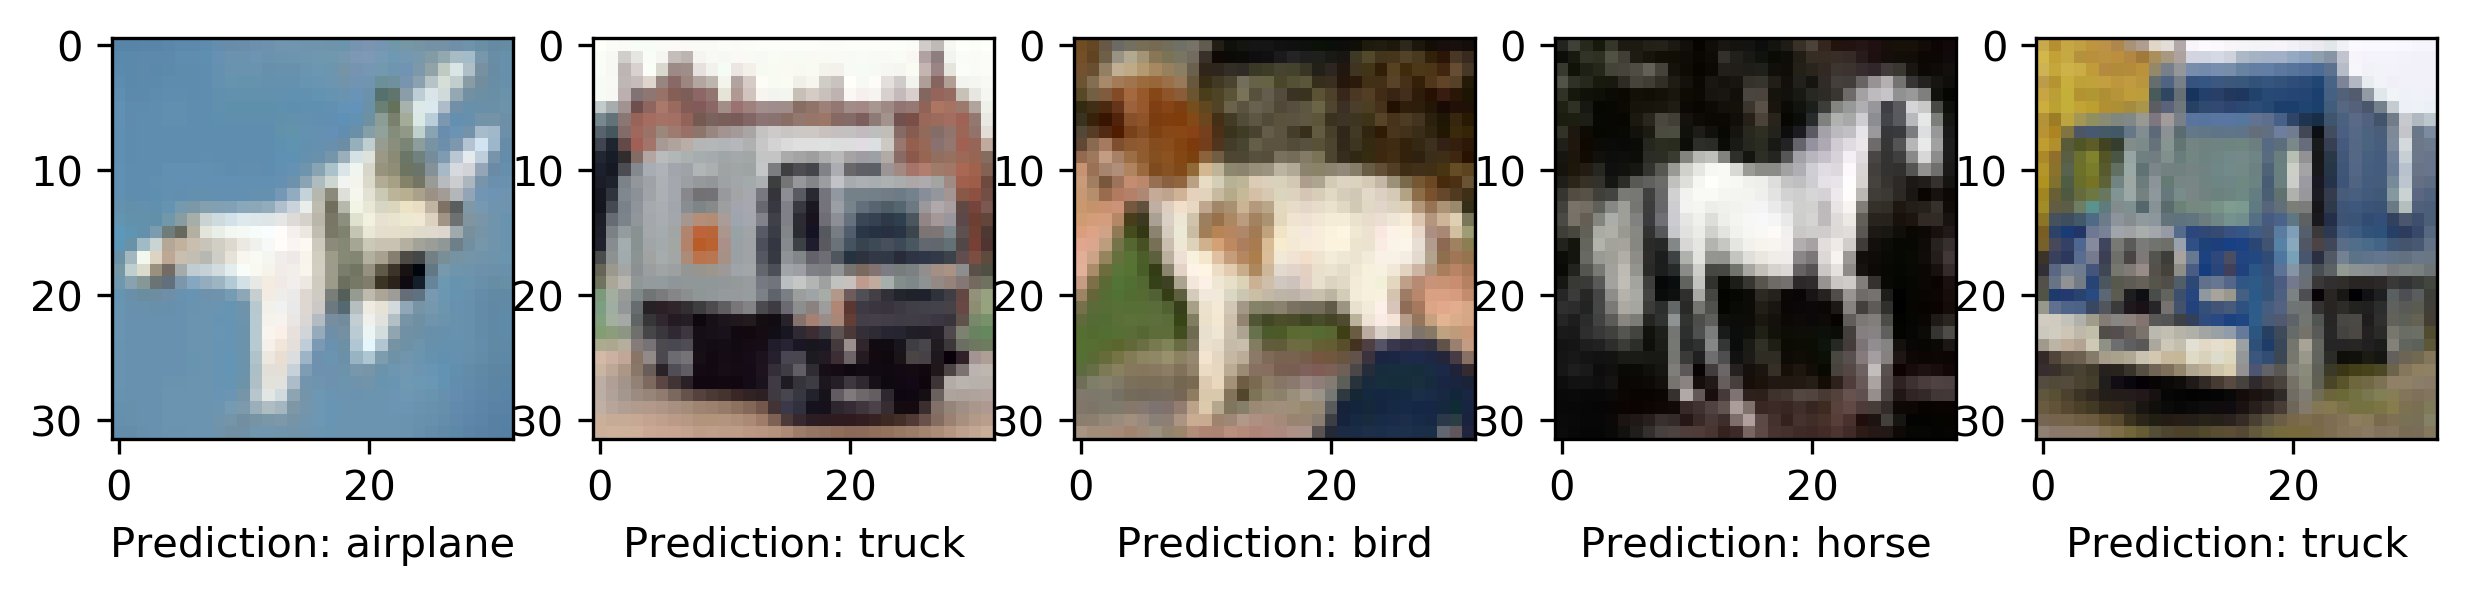

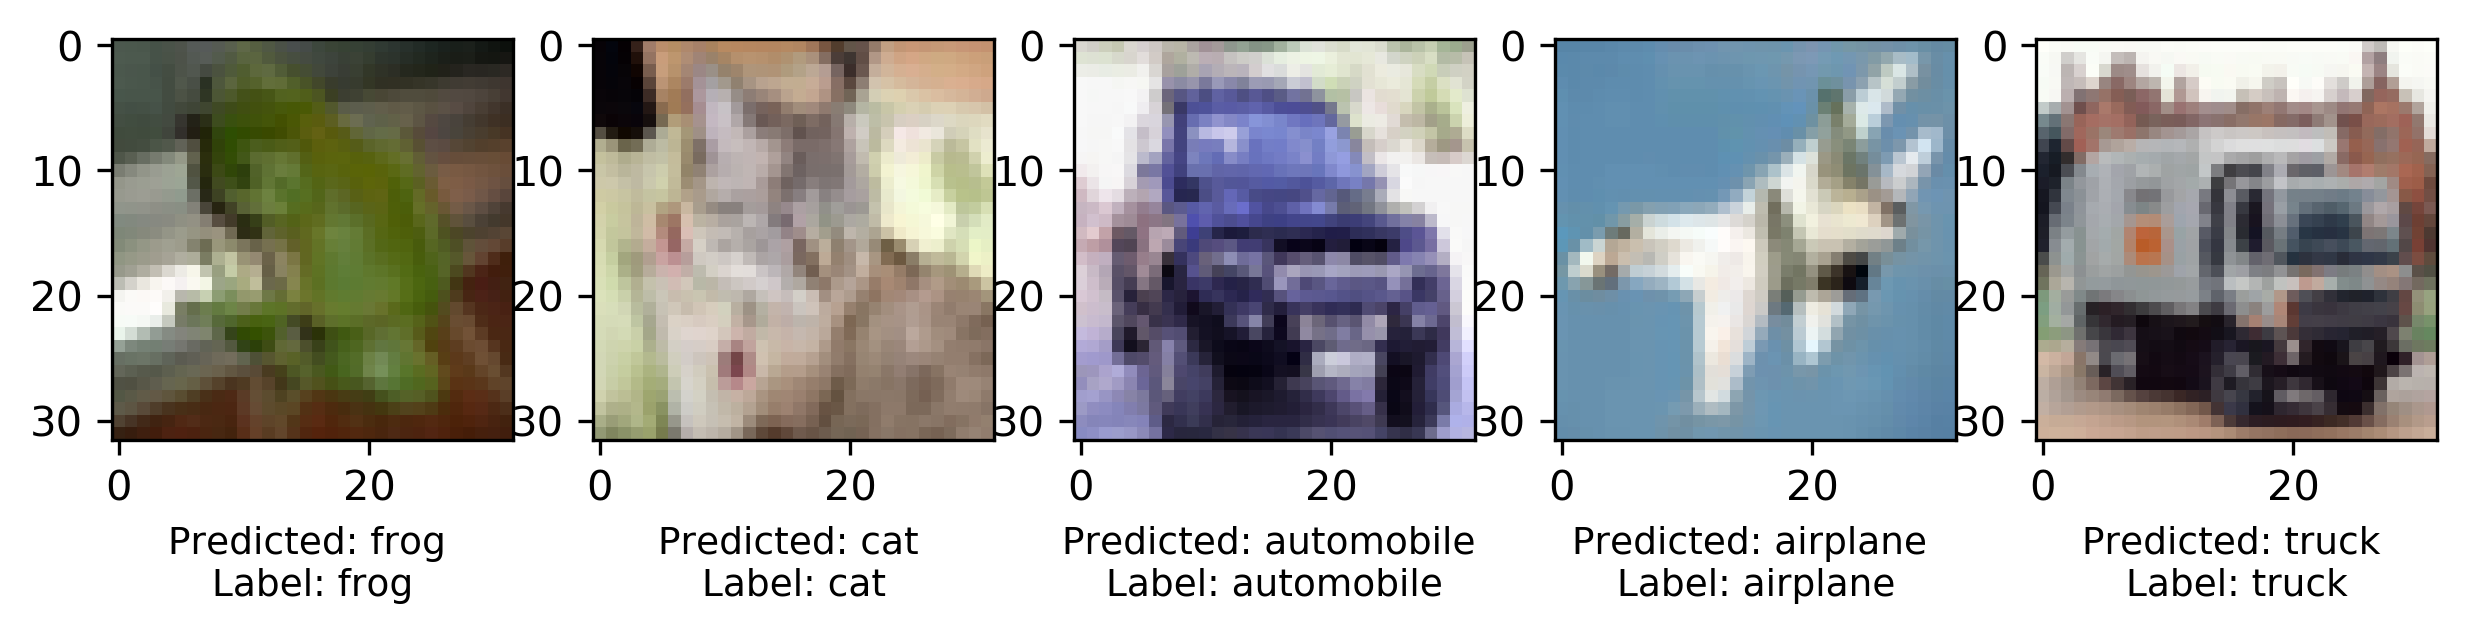

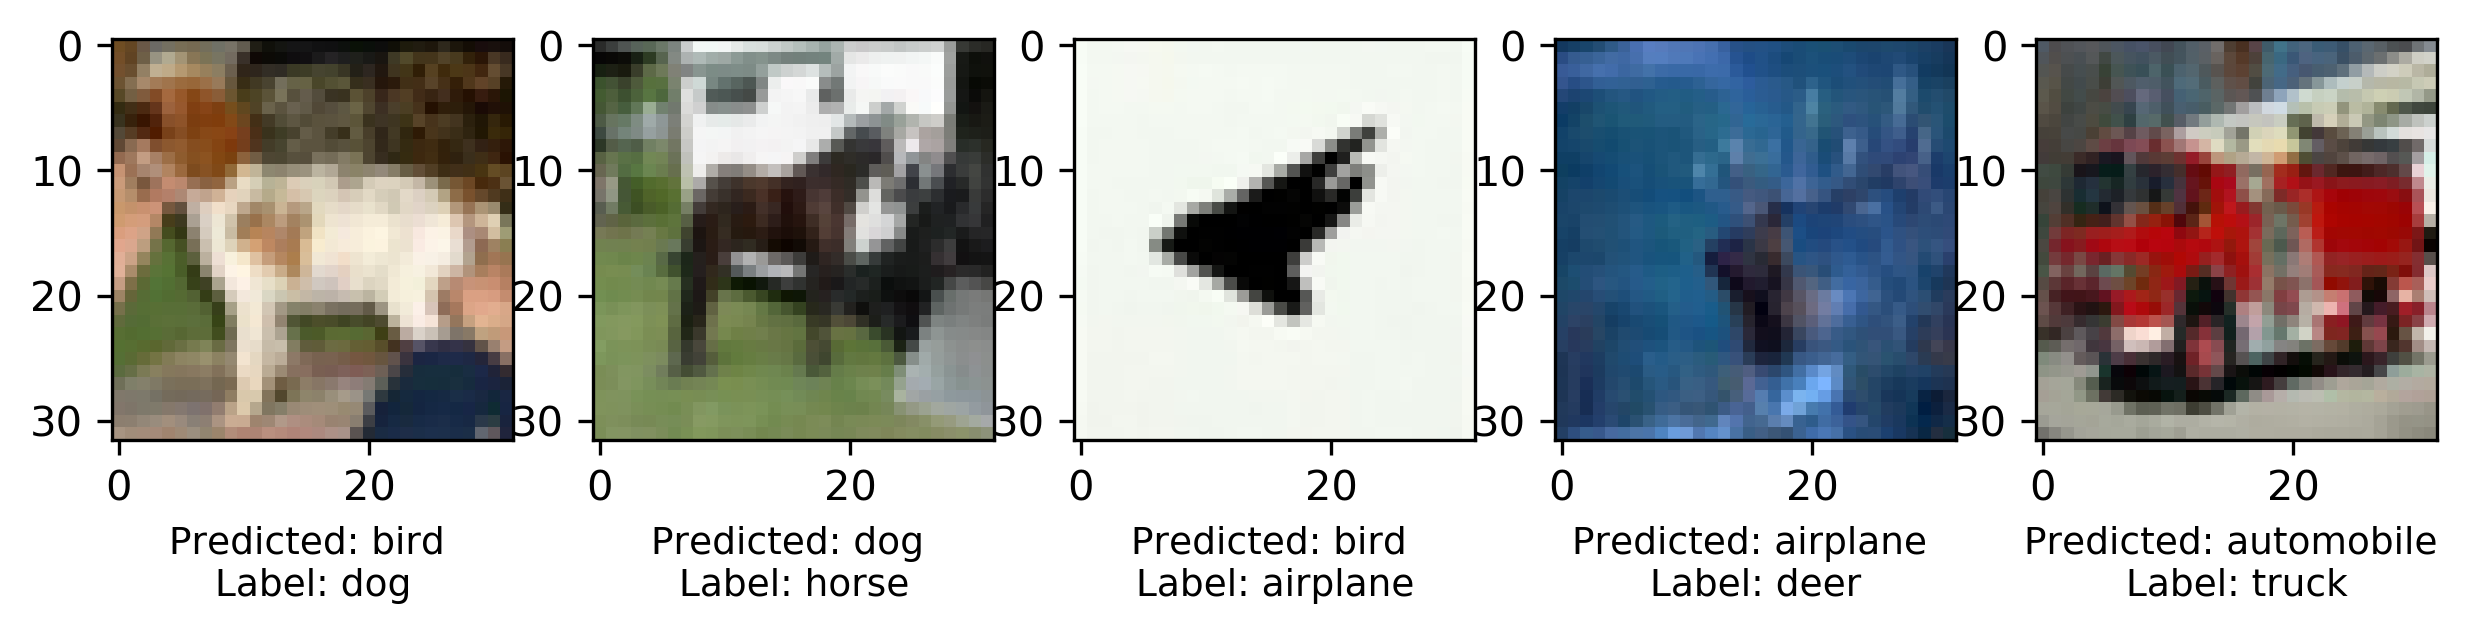

In [29]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    
label_pred=[]
for i in range(0,len(testing_images)):
    predicted = model.predict_classes(testing_images[i].reshape(1,32,32,3))
    label_pred.append(predicted)
plt.figure(figsize=(10,4),dpi=300)
for index, (image, label) in enumerate(zip(testing_images[10:15], label_pred[10:15])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (32,32,3)), cmap=plt.cm.gray)
    plt.xlabel('Prediction: {}'.format(class_names[int(str(*label))]), fontsize = 10)
    plt.savefig('prediction.png')
    
idx = 0
correct = []
correct_lbl=[]
classifiedIndexes = []
for label, predict in zip(test_lbl, label_pred):
    if predict == label: 
        classifiedIndexes.append(idx)
    idx +=1
plt.figure(figsize=(10,4),dpi=300)
for plotIndex, goodIndex in enumerate(classifiedIndexes[5:10]):
    plt.subplot(1, 5, plotIndex + 1)
    correct.append(*label_pred[goodIndex])
    correct_lbl.append(test_lbl[goodIndex])
    plt.imshow(np.reshape(testing_images[goodIndex], (32,32,3)), cmap=plt.cm.gray)
    plt.xlabel('Predicted: {} \nLabel: {}'.format(class_names[int(str(*label_pred[goodIndex]))],
                                                 class_names[int(str(test_lbl[goodIndex]))]), fontsize = 9)
    plt.savefig('classified.png')
    
index = 0
incorrect =[]
incorrect_lbl=[]
misclassifiedIndexes = []
for label, predict in zip(test_lbl, label_pred):
    if predict != label: 
        misclassifiedIndexes.append(index)
    index +=1
plt.figure(figsize=(10,4),dpi=300)
for plotIndex, badIndex in enumerate(misclassifiedIndexes[2:7]):
    plt.subplot(1, 5, plotIndex + 1)
    incorrect.append(*label_pred[badIndex])
    incorrect_lbl.append(test_lbl[badIndex])
    plt.imshow(np.reshape(testing_images[badIndex], (32,32,3)))
    plt.xlabel('Predicted: {} \nLabel: {}'.format(class_names[int(str(*label_pred[badIndex]))],
                                                 class_names[int(str(test_lbl[badIndex]))]), fontsize = 9)
    plt.savefig('miss-classified.png')

    
    

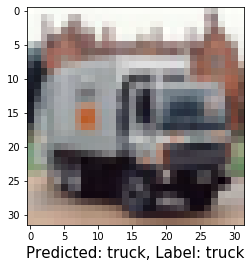

In [53]:
plt.imshow(np.reshape(testing_images[goodIndex], (32,32,3)), cmap=plt.cm.gray)
plt.xlabel('Predicted: {}, Label: {}'.format(class_names[int(str(*label_pred[goodIndex]))],
                                                 class_names[int(str(test_lbl[goodIndex]))]), fontsize = 15)
plt.savefig('f-plt-g.png')

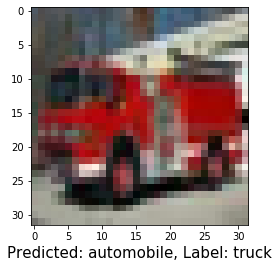

In [54]:

plt.imshow(np.reshape(testing_images[badIndex], (32,32,3)), cmap=plt.cm.gray)
plt.xlabel('Predicted: {}, Label: {}'.format(class_names[int(str(*label_pred[badIndex]))],
                                                 class_names[int(str(test_lbl[badIndex]))]), fontsize = 15)
plt.savefig('f-plt-b.png')

Displaying activation map 0


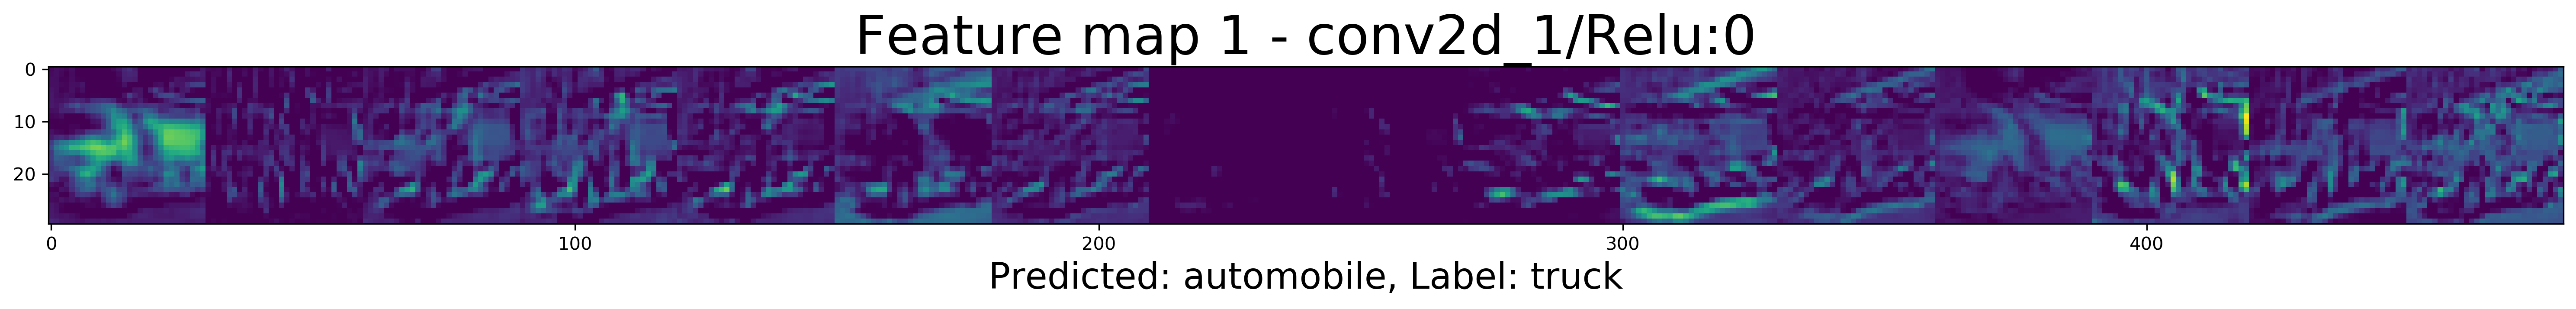

Displaying activation map 1


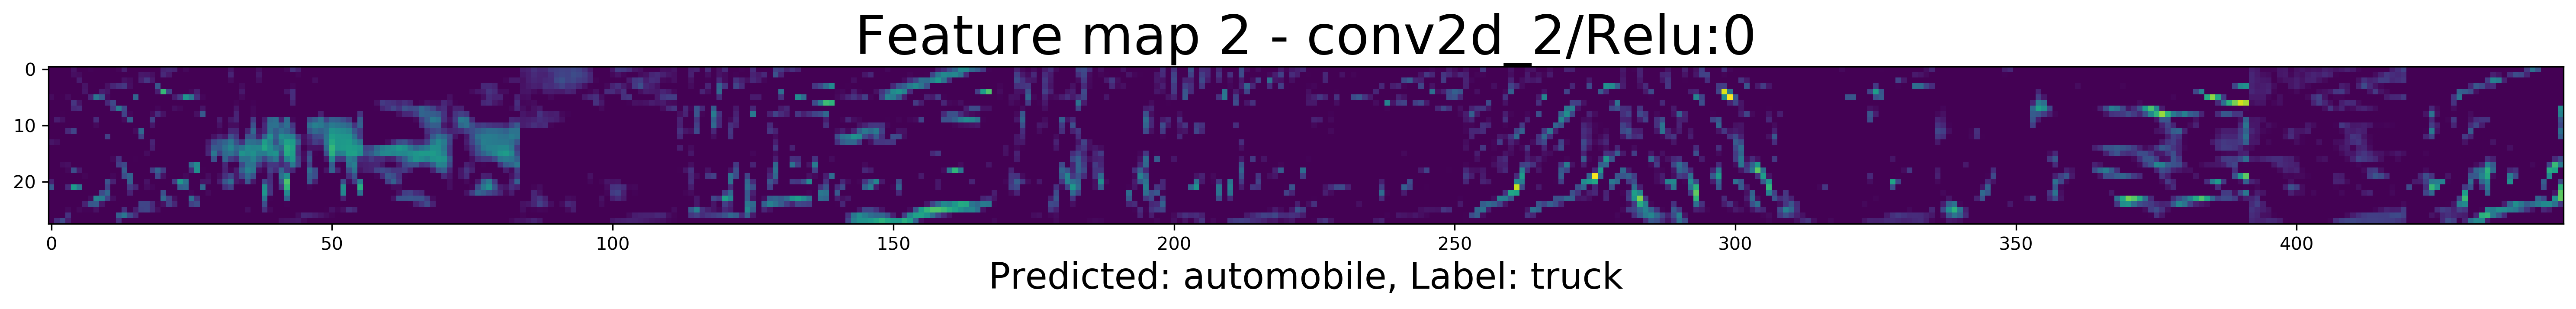

Displaying activation map 2


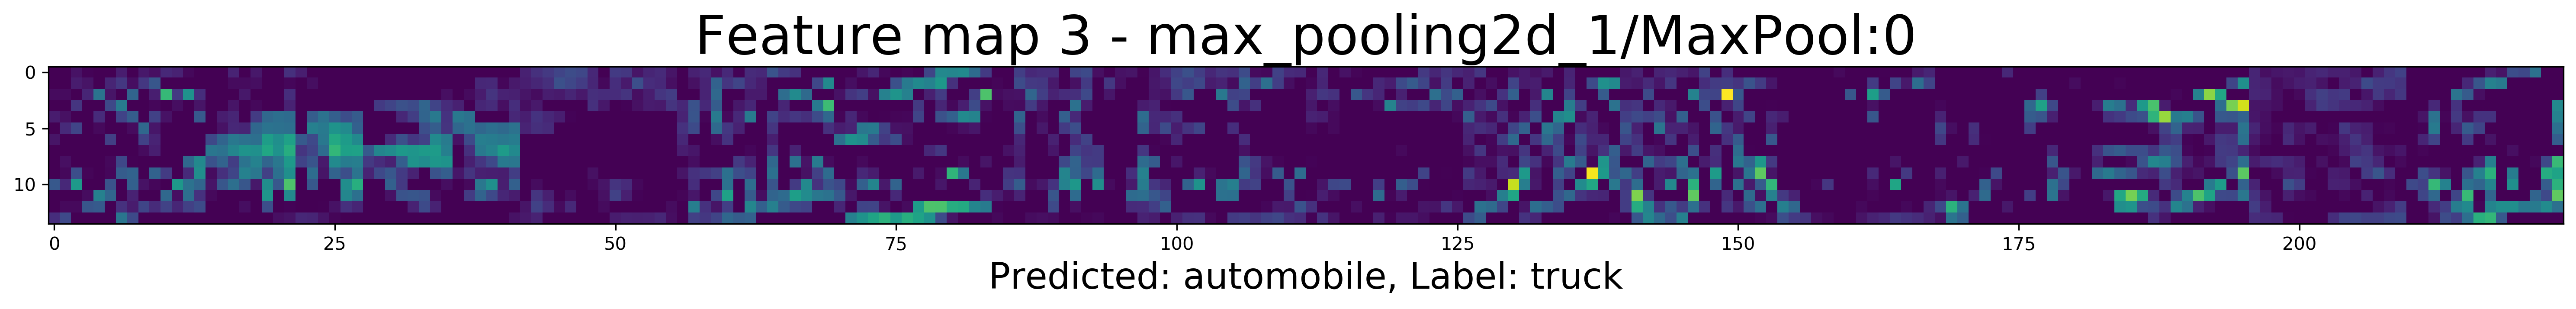

Displaying activation map 3


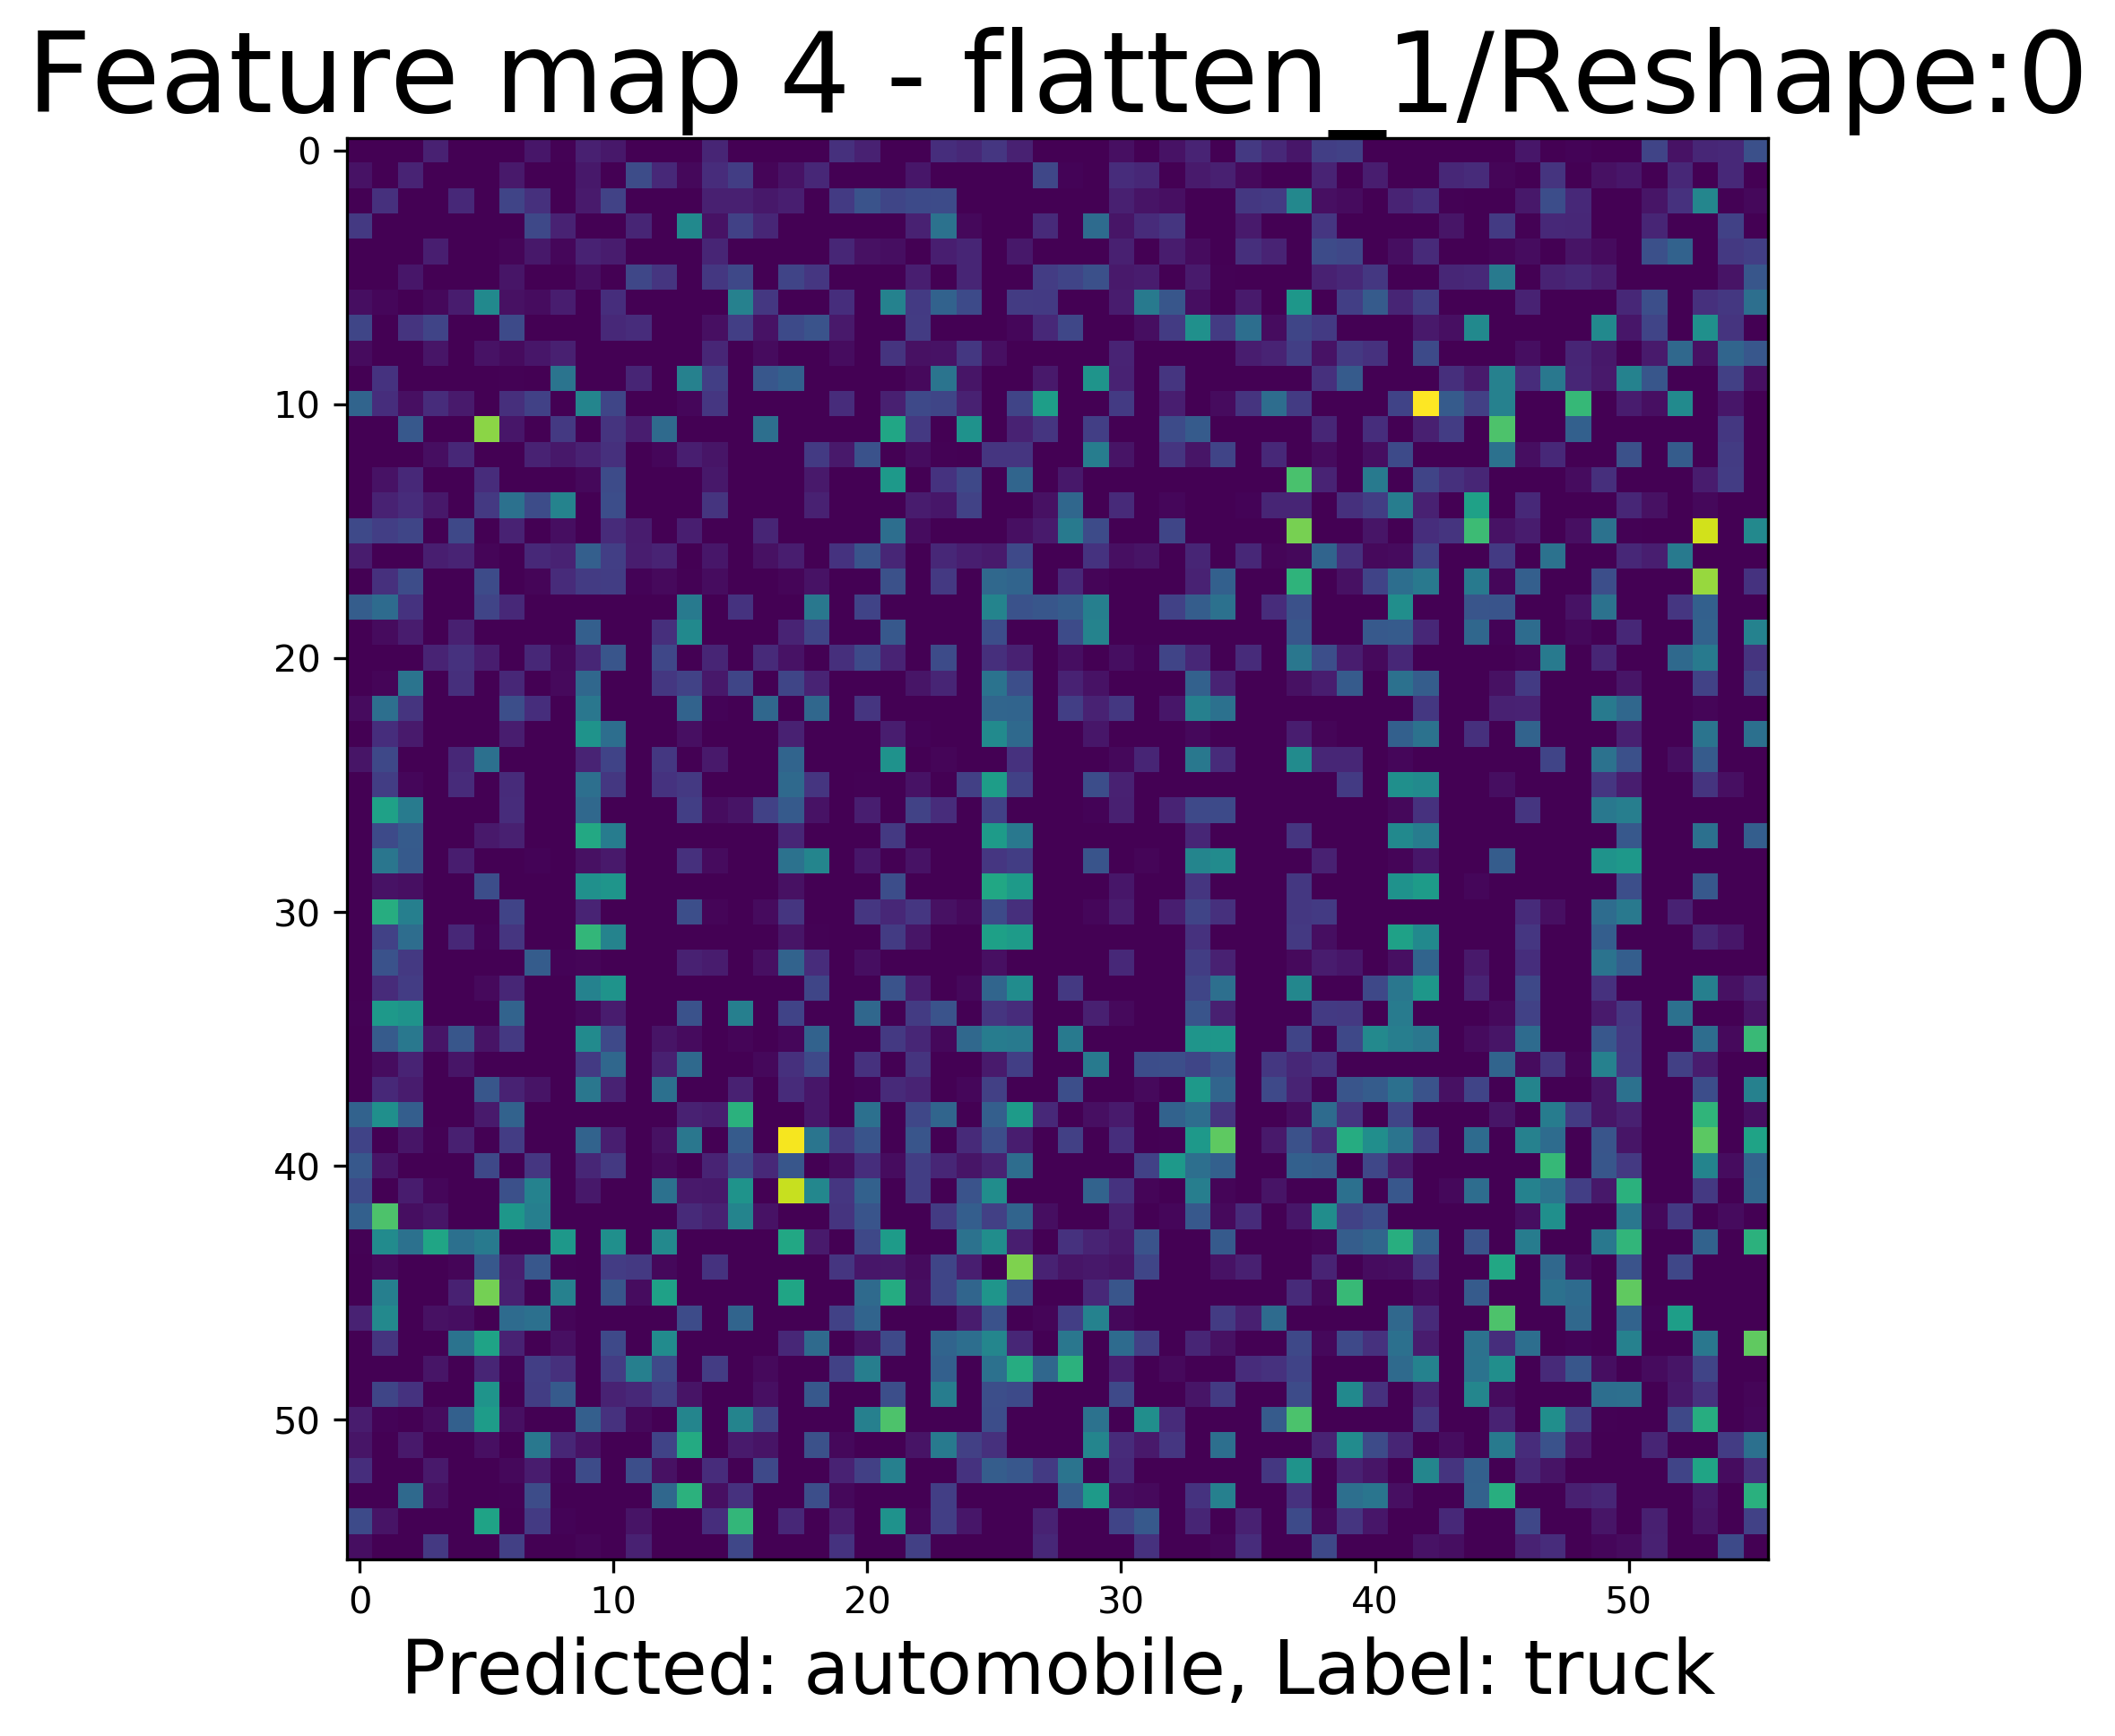

Displaying activation map 4


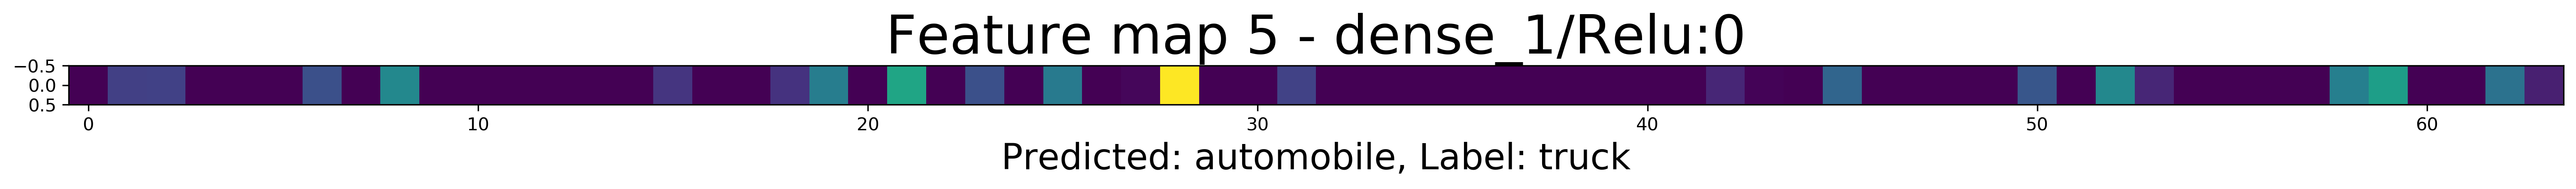

Displaying activation map 5


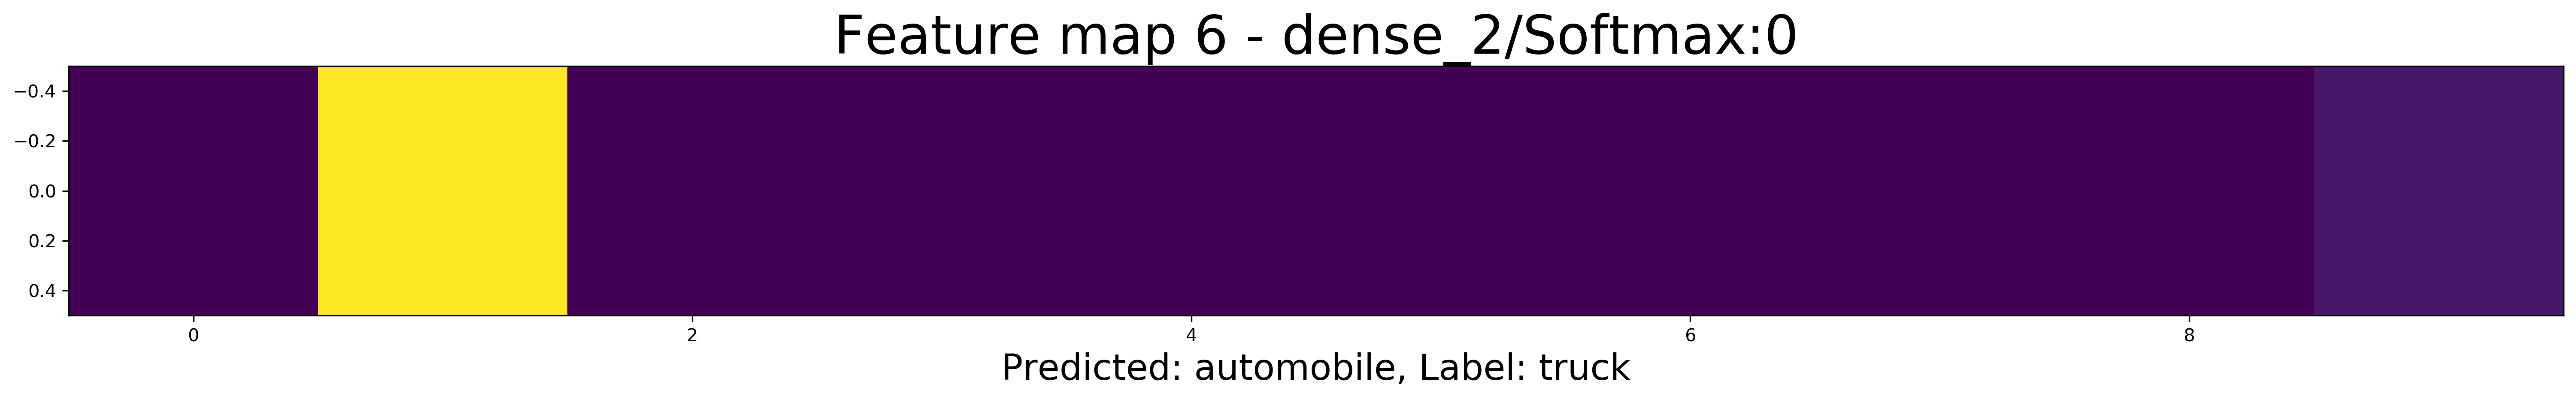

In [55]:
layer_plot = 0
def feature_maps(model, model_inputs, layer_name=None):
    feature_maps = []
    inp_mod = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp_mod, list):
        # only one input! let's wrap it in a list.
        inp_mod = [inp_mod]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  
    outputs = [output for output in outputs if 'input_' not in output.name]

    funcs = [K.function(inp_mod + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    feature_maps = [func(list_inputs)[0] for func in funcs]
    layer_names = [output.name for output in outputs]

    result = dict(zip(layer_names, feature_maps))
    return result


def features_plot(features,layer_plot):
    layer_names = list(features.keys())
    feature_maps = list(features.values())
    batch_size = feature_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, f_map in enumerate(feature_maps):
        plt.close()
        print('Displaying activation map {}'.format(i))
        shape = f_map.shape
        if len(shape) == 4:
            features = np.hstack(np.transpose(f_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            features = f_map[0]
            num_features = len(features)
            if num_features > 1024: 
                square_size = int(np.floor(np.sqrt(num_features)))
                features = features[0: square_size * square_size]
                features = np.reshape(features, (square_size, square_size))
            else:
                features = np.expand_dims(features, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.figure(layer_plot,figsize=(25,7),dpi=300)
        plt.title('Feature map ' +str(i+1) +' - '+ layer_names[i],fontsize=30)
        plt.xlabel('Predicted: {}, Label: {}'.format(class_names[int(str(*label_pred[badIndex]))], class_names[int(str(test_lbl[badIndex]))]), fontsize = 20)
        plt.imshow(features, interpolation='None')
        plt.savefig('layer_' +str(i)+'_b.png')
        layer_plot += 1
        plt.show()
    return layer_plot

feature_maps = feature_maps(model, testing_images[misclassifiedIndexes[6]].reshape(1,32,32,3))
layer_plot = features_plot(feature_maps,layer_plot)

Displaying activation map 0


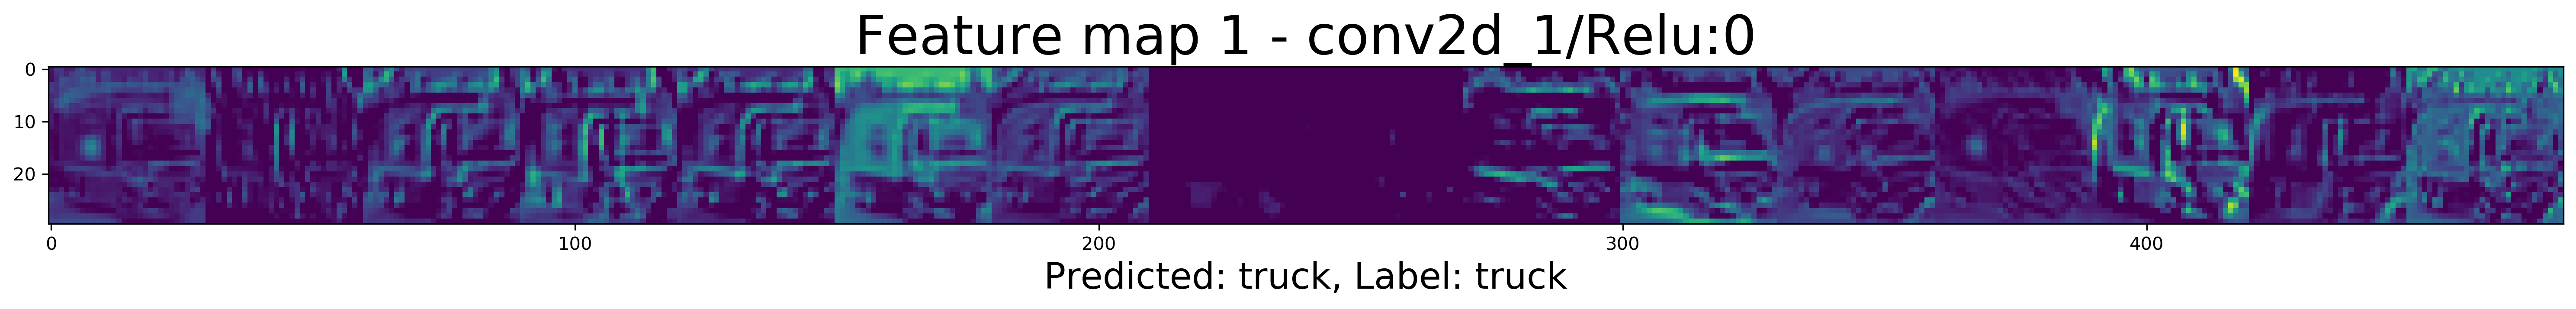

Displaying activation map 1


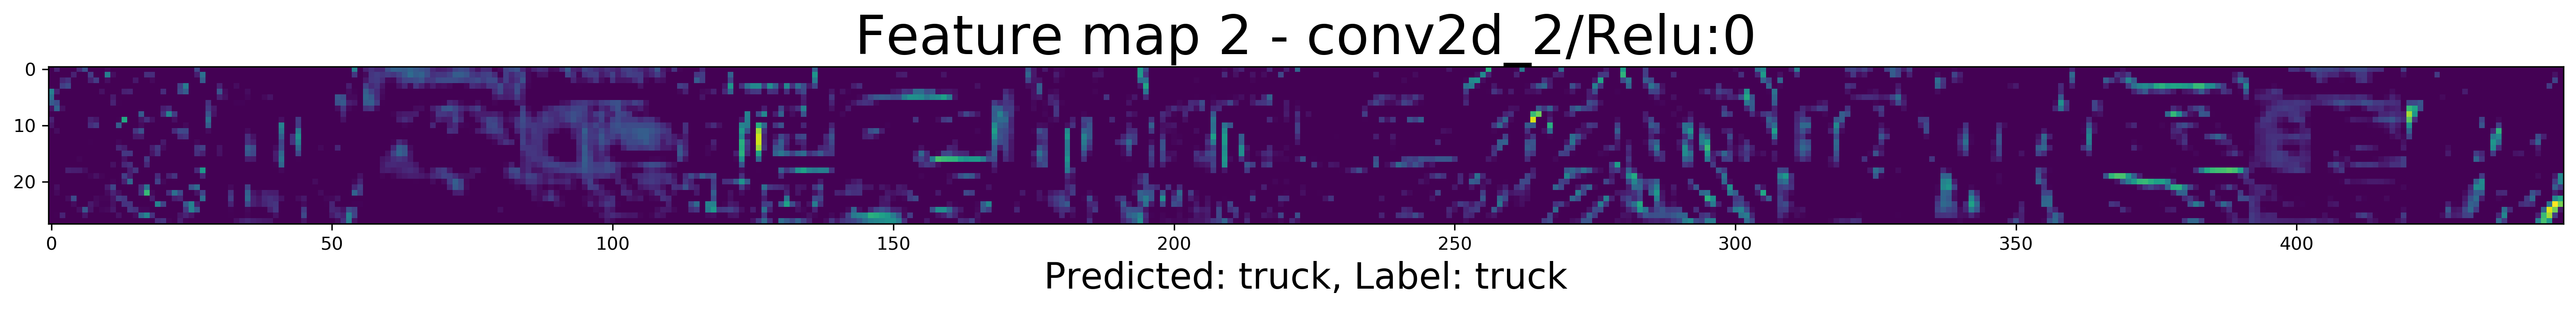

Displaying activation map 2


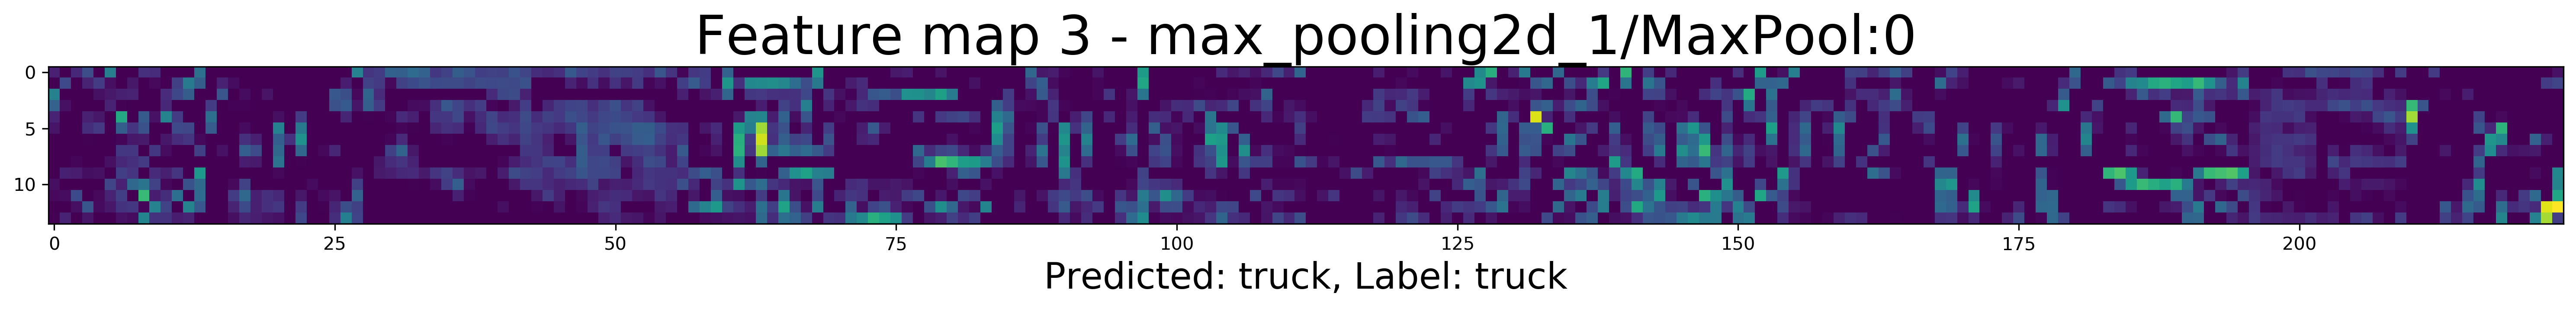

Displaying activation map 3


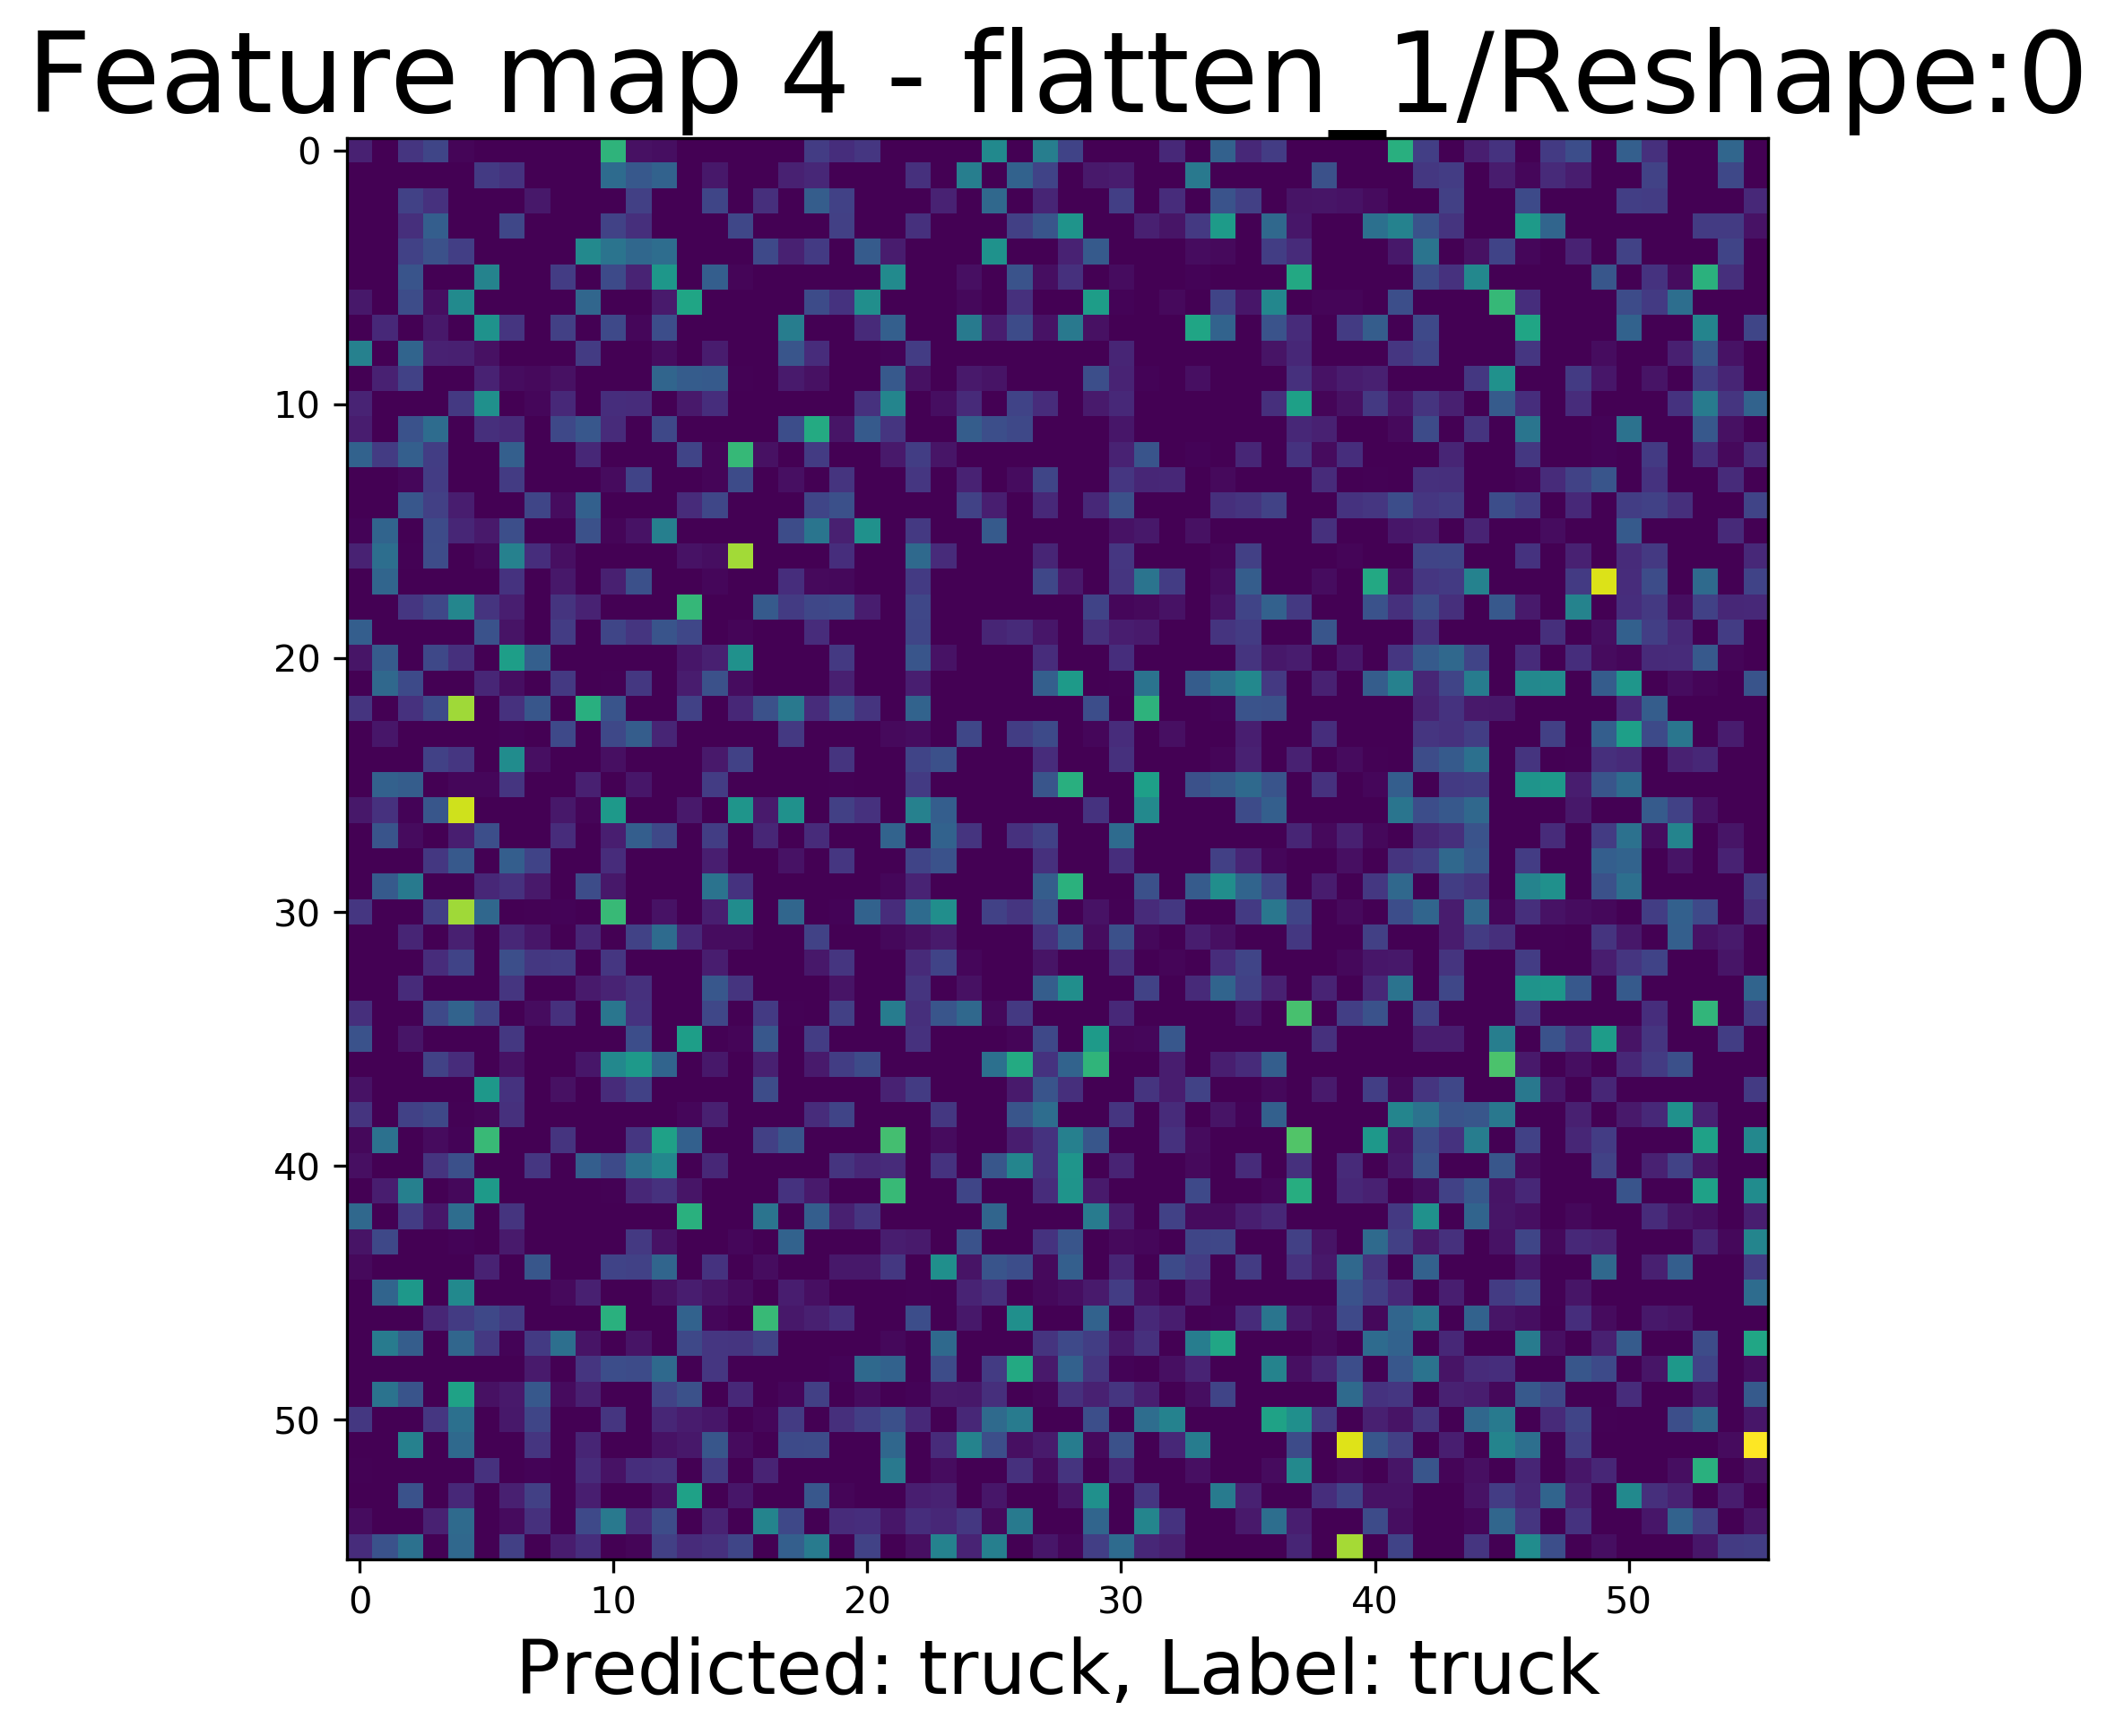

Displaying activation map 4


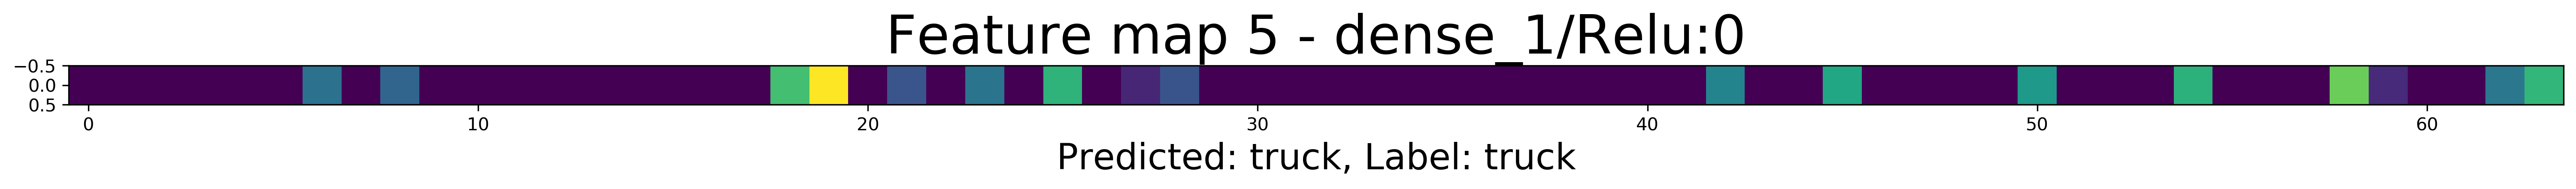

Displaying activation map 5


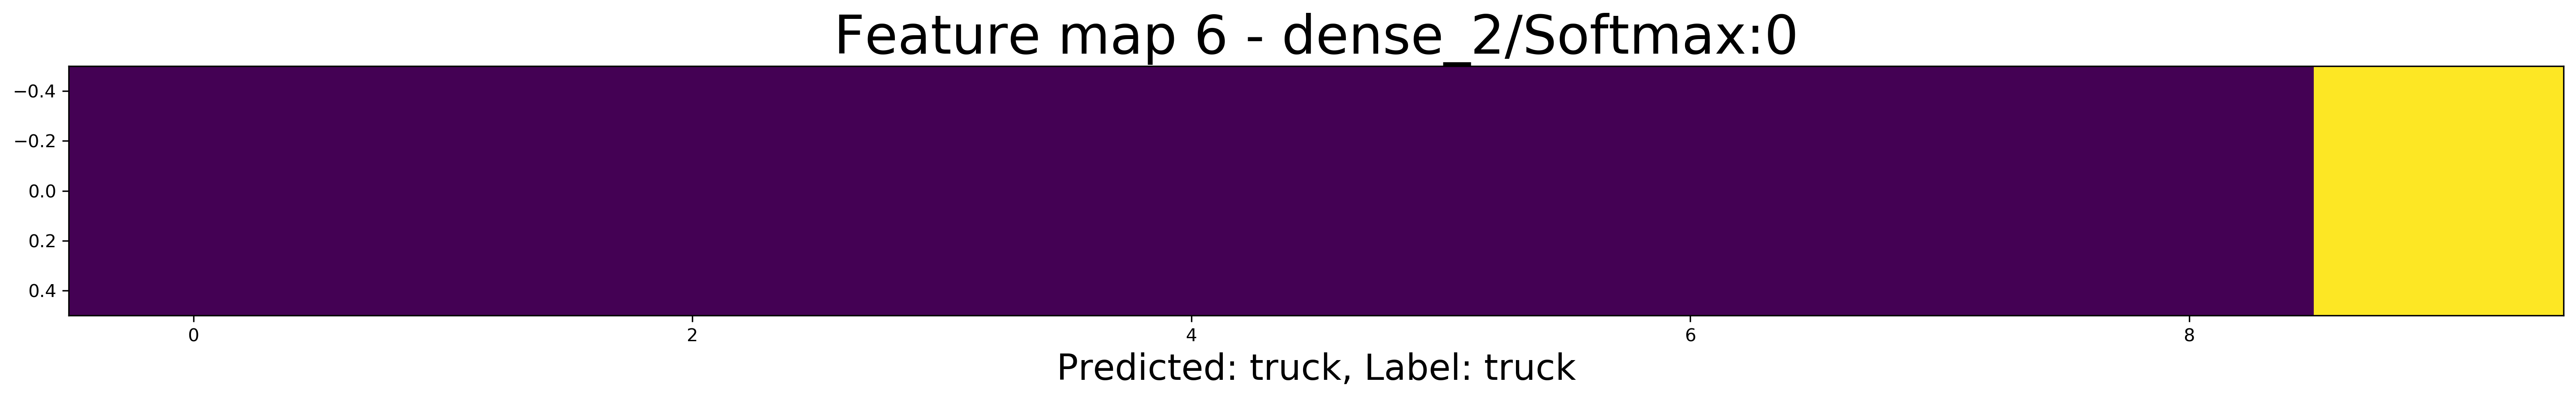

In [56]:
layer_plot = 0
def feature_maps(model, model_inputs, layer_name=None):
    feature_maps = []
    inp_mod = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp_mod, list):
        # only one input! let's wrap it in a list.
        inp_mod = [inp_mod]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  
    outputs = [output for output in outputs if 'input_' not in output.name]

    funcs = [K.function(inp_mod + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    feature_maps = [func(list_inputs)[0] for func in funcs]
    layer_names = [output.name for output in outputs]

    result = dict(zip(layer_names, feature_maps))
    return result


def features_plot(features,layer_plot):
    layer_names = list(features.keys())
    feature_maps = list(features.values())
    batch_size = feature_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, f_map in enumerate(feature_maps):
        plt.close()
        print('Displaying activation map {}'.format(i))
        shape = f_map.shape
        if len(shape) == 4:
            features = np.hstack(np.transpose(f_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            features = f_map[0]
            num_features = len(features)
            if num_features > 1024: 
                square_size = int(np.floor(np.sqrt(num_features)))
                features = features[0: square_size * square_size]
                features = np.reshape(features, (square_size, square_size))
            else:
                features = np.expand_dims(features, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.figure(layer_plot,figsize=(25,7),dpi=300)
        plt.title('Feature map ' +str(i+1) +' - '+ layer_names[i],fontsize=30)
        plt.xlabel('Predicted: {}, Label: {}'.format(class_names[int(str(*label_pred[goodIndex]))], 
                                                     class_names[int(str(test_lbl[goodIndex]))]), fontsize = 20)
        plt.imshow(features, interpolation='None')
        plt.savefig('layer_' +str(i)+'_g.png')
        layer_plot += 1
        plt.show()
    return layer_plot

feature_maps = feature_maps(model, testing_images[classifiedIndexes[9]].reshape(1,32,32,3))
layer_plot = features_plot(feature_maps,layer_plot)